# Chronological distribution of road-related terms on inscriptions

**Research idea:** Petra Hermankova, Aarhus University

**Script & technical solution:**  Vojtech Kase, Aarhus University

Source:  https://github.com/sdam-au/social_diversity/

In [50]:
import pandas as pd
import numpy as np
import nltk
import requests
import re
import json

from nltk import ngrams

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import seaborn as sns

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [51]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
terms = gc.open_by_url("https://docs.google.com/spreadsheets/d/1tdtjPCoHY61FSZB0CxAdZXN9xDgl76KU-ObMp4uNG2A/edit#gid=0")

sciencedata.dk username (format '123456@au.dk'): 648560@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [52]:
# read datasets in public folders

publicfolder = "66cbabddae0e02c6ae6c15be9746990c/"

EDH = sddk.read_file("EDH_terms_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_terms_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [53]:
EDH.head(2)

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,terms,terms_N
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,Dis Manibus Noniae Publi filiae Optatae et Cai...,None,None,None,None,None,None,None,[],0
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",None,...,Caius Sextius Paris qui vixit annis LXX,"Via Nomentana, S. Alessandro, Kirche",1937,None,None,None,None,None,[],0


In [54]:
EDCS.head(2)

,EDCS-ID,publication,province,place,notes_dating,notes_references,notes_comments,inscription,inscription_stripped14,clean_text_interpretive_word,...,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,terms,terms_N
0,EDCS-31400030,"CIL 03, 12297",Achaia,?,,,,Leius,Leius,Leius,...,None,None,None,None,None,None,None,None,[],0
1,EDCS-24700151,"CIL 01, 02650 (p 1097) = IG-05-01, 00741 = ILL...",Achaia,Afesou,,,,// D(ecimi) Leivei D(ecimi) Leivei salve,// D(ecimi) Leivei D(ecimi) Leivei salve,Decimi Leivei Decimi Leivei salve,...,None,None,None,None,None,None,None,None,[],0


In [55]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [56]:
def get_date_from_randoms(value, n):
    """extract individual date on the basis of index
    (used in sim_data_by_function)"""
    try:
        return value[n]
    except:
        return None

def sim_data_by_function(df, n_sims, timeblocks, function, *args, random_dates_column="random_dates"):
    """
    retrieve simulation variants from random dates
    params:
        df : dataframe containing column with random dates (by default, named "random_dates")
        n_sims : number of simulation to produce (lower than- or equeal to the length "random_dates" array)
        timeblocks : list or tuple specifying startdate, enddate and steps of the timeblocks (e.g. "[-200, 600, 100]")
        function : any function taking a dataframe as its first and main input, using it for some computation (e.g. total number of words in certain column), and returning a numerical output
        *args : additional arguments to be used by the function
        random_dates_column : column containing the preassigned random dates 
    returns:
        list of simulation data of `n_sims` length
    """
    complete_sim_data = []
    for n in range(n_sims):
        sim = df[random_dates_column].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in get_timeblocks(timeblocks[0], timeblocks[1], timeblocks[2]):
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

# Inscription types over time

In [57]:
EDH["type_of_inscription_clean"]

0                      epitaph
1                      epitaph
2        honorific inscription
3           votive inscription
4                      epitaph
                 ...          
81471                     NULL
81472                     NULL
81473       votive inscription
81474       votive inscription
81475       votive inscription
Name: type_of_inscription_clean, Length: 81476, dtype: object

In [58]:
simulations_by_type_len = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type]
        simulations_by_type_len.append((ins_type, len(subset_df)))
simulations_by_type_len = sorted(simulations_by_type_len, key = lambda x: x[1], reverse=True)
simulations_by_type_len

[('epitaph', 27953),
 ('votive inscription', 14044),
 ('owner/artist inscription', 5185),
 ('honorific inscription', 3999),
 ('building/dedicatory inscription', 3307),
 ('mile-/leaguestone', 1730),
 ('identification inscription', 1574),
 ('acclamation', 533),
 ('military diploma', 500),
 ('list', 360),
 ('defixio', 309),
 ('label', 289),
 ('public legal inscription', 248),
 ('boundary inscription', 246),
 ('elogium', 143),
 ('letter', 121),
 ('seat inscription', 87),
 ('prayer', 56),
 ('private legal inscription', 45),
 ('assignation inscription', 16),
 ('calendar', 14),
 ('adnuntiatio', 3)]

In [59]:
%%time
# generate column with random umbers
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], 1000), axis=1)

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 38.6 µs


In [68]:
EDH.head(2)

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,terms,terms_N,random_dates
0,Feraudi,epitaph,3.2-2 cm,0130,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",provisional,33 cm,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"[{'name': 'Noniae P.f. Optatae', 'cognomen': '...",2.7 cm,...,None,None,None,None,None,None,None,[],0,"[126, 115, 76, 100, 107, 93, 100, 91, 92, 118,..."
1,Feraudi,epitaph,4 cm,0200,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",None,...,"Via Nomentana, S. Alessandro, Kirche",1937,None,None,None,None,None,[],0,"[99, 147, 168, 192, 70, 182, 163, 85, 112, 137..."


In [63]:
%%time
simulations_by_type = []

for ins_type_tup in simulations_by_type_len[:7]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    simulations = timeblocks_from_randoms(subset_df, "random_dates", [-200, 600, 100])
    ins_type_N =len(subset_df)
    simulations_by_type.append([ins_type_tup[0],ins_type_N, simulations]) 
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 39.3 µs


In [64]:
simulations_by_type = sorted(simulations_by_type, key=lambda x: x[1], reverse=True)

In [65]:
from matplotlib.patches import Patch

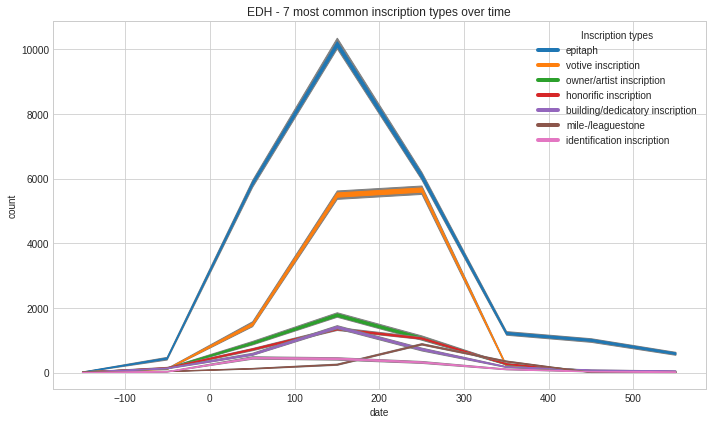

In [115]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-whitegrid")

fig, ax  = plt.subplots(figsize=(10, 6), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type, tab_colors_list[:len(simulations_by_type)]):
    plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)
    
ax.set_xlabel("date")
ax.set_ylabel("count")
ax.set_title("EDH - 7 most common inscription types over time")
 
markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in tab_colors_list[:len(simulations_by_type)]]
plt.legend(markers, [tup[0] for tup in simulations_by_type], numpoints=1,  title="Inscription types", bbox_to_anchor=(1, 1), loc='upper right')

In [114]:
sddk.write_file("SDAM_data/epigraphic_roads/EDH_inscription_types_temporal.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/epigraphic_roads/EDH_inscription_types_temporal.png"


In [69]:
def wordcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()

def wordcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of words in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum() / len(timeblock_df)

def charcount(timeblock_df, column="clean_text_interpretive_word"):
    """number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()

def charcount_avg(timeblock_df, column="clean_text_interpretive_word"):
    """average number of characters in inscriptions within timeblock"""
    return timeblock_df[column].astype(str).apply(lambda x: len(x)).sum() / len(timeblock_df)

def unique_words(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock"""
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words

def unique_words_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique words in inscriptions within timeblock
    in proportion to total number of words"""
    wordcount = timeblock_df[column].astype(str).apply(lambda x: len(x.split())).sum()
    inscriptions_list = timeblock_df[column].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_words / wordcount

def extract_ngrams(text, width=4):
    """extracts character ngrams from a string of given width
    returns: list of ngrams"""
    char_ngrams = ["".join(ngram) for ngram in list(ngrams(str(text), width))]
    return char_ngrams

def unique_ngrams(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique)

def unique_ngrams_weighted(timeblock_df, column="clean_text_interpretive_word"):
    """number of unique ngrams in inscriptions within timeblock
    in proportion to total number of characters"""
    ngrams_series = timeblock_df[column].astype(str).apply(extract_ngrams)
    all_ngrams = [el for sublist in ngrams_series for el in sublist]
    all_ngrams_unique = list(set(all_ngrams))
    charcount = timeblock_df[column].astype(str).apply(lambda x: len(x)).sum()
    return len(all_ngrams_unique) / charcount


In [70]:
for ins_type_tup in simulations_by_type_len[:7]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    print(ins_type_tup[0], subset_df["terms_N"].sum())
    #subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]

epitaph 282
votive inscription 234
owner/artist inscription 16
honorific inscription 127
building/dedicatory inscription 147
mile-/leaguestone 182
identification inscription 4


In [71]:
types, frequencies = [], []

for ins_type_tup in simulations_by_type_len[:7]:
    subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]
    subset_wordcount = wordcount(subset_df).sum()
    types.append(ins_type_tup[0])
    frequencies.append(subset_df["terms_N"].sum() / subset_wordcount)
    print(ins_type_tup[0], subset_df["terms_N"].sum() / subset_wordcount)
    #subset_df = EDH[EDH["type_of_inscription_clean"]==ins_type_tup[0]]

epitaph 0.0008000998706221486
votive inscription 0.0015105642667630674
owner/artist inscription 0.0009225624171135329
honorific inscription 0.0013784121126607695
building/dedicatory inscription 0.002869412453640445
mile-/leaguestone 0.004612148703783483
identification inscription 0.0006308153288124901


CPU times: user 28.1 ms, sys: 4.99 ms, total: 33.1 ms
Wall time: 29.1 ms


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


Text(0.5, 1.0, 'Classification of inscriptions containing road vocabulary and their frequency')

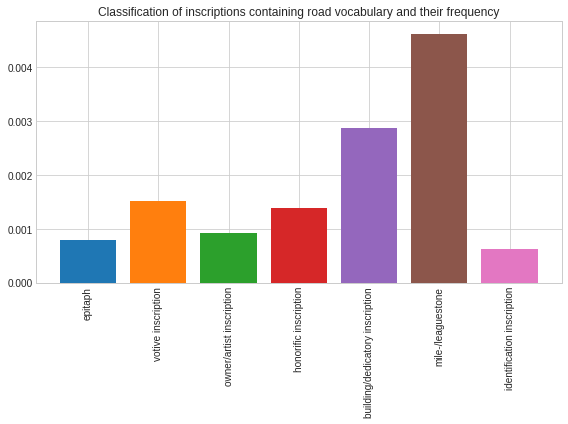

In [78]:
%%time
fig, ax  = plt.subplots(figsize=(8, 6), tight_layout=True)
plt.style.use("seaborn-whitegrid")

ax.bar(types, frequencies, color=tab_colors_list[:len(simulations_by_type)])
y_pos = range(len(types))
ax.set_xticks(y_pos, types)
ax.set_xticklabels(labels = types, rotation="vertical")
ax.set_title("Classification of inscriptions containing road vocabulary and their frequency")

In [96]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648560@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its ordinary user
endpoint variable has been configured to: https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/


In [97]:
sddk.write_file("SDAM_data/epigraphic_roads/EDH_terms_by_instypes.png", fig, conf)


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/epigraphic_roads/EDH_terms_by_instypes.png"


# Wordcount & character count over time

In [85]:
%%time
charcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount)

CPU times: user 32.2 s, sys: 2.67 s, total: 34.9 s
Wall time: 31.3 s


In [86]:
charcounts_data[0]

[((-200, -151), 16320),
 ((-150, -101), 17108),
 ((-100, -51), 30027),
 ((-50, -1), 97881),
 ((1, 50), 411742),
 ((51, 100), 598922),
 ((101, 150), 977832),
 ((151, 200), 1239507),
 ((201, 250), 1180527),
 ((251, 300), 515960),
 ((301, 350), 182432),
 ((351, 400), 118161),
 ((401, 450), 57360),
 ((451, 500), 34353),
 ((501, 550), 26016),
 ((551, 600), 31510)]

In [87]:
%%time
wordcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount) 
wordcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], wordcount_avg) 
charcounts_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount) 
charcounts_avg_data = sim_data_by_function(EDH, 100, [-200, 600, 50], charcount_avg) 
unique_words_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_words)
unique_ngrams_data = sim_data_by_function(EDH, 100, [-200, 600, 50], unique_ngrams)

CPU times: user 7min 31s, sys: 32.6 s, total: 8min 3s
Wall time: 7min 41s


In [88]:
sim_data_list = [
    (wordcounts_data, "(A) EDH - wordcounts", "wordcount"),
    (wordcounts_avg_data, "(B) EDH - average wordcounts per inscription", "avr. wordcount"),
    (charcounts_data,  "(C) EDH - character counts", "character count"),
    (charcounts_avg_data, "(D) EDH - average character counts per inscription", "avr. char. count"),
    (unique_words_data, "(E) EDH - unique words counts", "count"),
    (unique_ngrams_data, "(F) EDH - unique character four-grams", "count")]

In [89]:
def get_min_max_conf(sim_data, conf_int):
    min_max_conf = []
    for tb_n in range(len(sim_data[0])):
        tb_all_results = [sim[tb_n][1] for sim in sim_data]
        tb_all_results = sorted(tb_all_results)
        conf_int_d = (100 - conf_int) / 2 / 100
        conf_index = int(conf_int_d * len(sim_data))
        min_max_conf.append([tb_all_results[0], tb_all_results[-1], tb_all_results[conf_index], tb_all_results[-conf_index]])
    ys_min = [el[0] for el in min_max_conf]
    ys_max = [el[1] for el in min_max_conf]
    ys_conf_min = [el[2] for el in min_max_conf]
    ys_conf_max = [el[3] for el in min_max_conf]
    xs = [np.mean(el[0]) for el in sim_data[0]]
    return [xs, ys_min, ys_max, ys_conf_min, ys_conf_max]

def plot_timeblocks_data(sim_data, ax=None, color="black"):
    """
    plot timeblocks data with confidence intervals 
    """
    if ax == None:
        fig, ax = plt.subplots()
    plot_data = get_min_max_conf(sim_data, 90)
    layers = []
    x = plot_data[0]
    layers.append(ax.fill(x + x[::-1], plot_data[1] +  plot_data[2][::-1], color="gray"))
    layers.append(ax.fill(x + x[::-1], plot_data[3] +  plot_data[4][::-1], color=color))
    return layers

def plot_timeblocks_data_lines(list_of_timeblocks_data, ax=None, color=None):
  """
  plot timeblocks data as a series of overlapping line plots 
  """
  layers = []
  for timeblocks in list_of_timeblocks_data:
    x = [np.mean(tuptup[0]) for tuptup in timeblocks]
    y = [tuptup[1] for tuptup in timeblocks]
    if ax != None:
        if color != None:
            layer = ax.plot(x, y, color=color)
        else: 
            layer = ax.plot(x, y)
    else:
        if color != None:
            layer = plt.plot(x, y, color=color)
        else: 
            layer = plt.plot(x, y)
    layers.append(layer)
  return layers

In [90]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
tab_colors_list

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [91]:
max([el[1] for el in wordcounts_data[0]])

182310

[-50000.0, 0.0, 50000.0, 100000.0, 150000.0, 200000.0]
[-250000.0, 0.0, 250000.0, 500000.0, 750000.0, 1000000.0, 1250000.0, 1500000.0]
[-5000.0, 0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0]
[0.0, 10000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0]


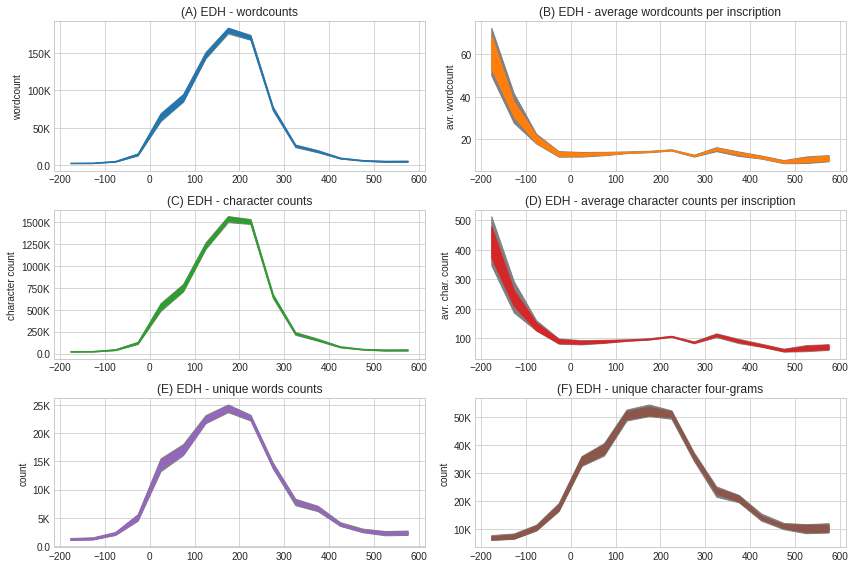

In [112]:
plt.style.use("seaborn-whitegrid")

fig, axs  = plt.subplots(3, 2, figsize=(12, 8), tight_layout=True)

for sim_data, ax, color in zip(sim_data_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        ax.set_yticklabels(ticks_K)

In [94]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648560@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its ordinary user
endpoint variable has been configured to: https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/


In [95]:
sddk.write_file("SDAM_data/epigraphic_roads/EDH_word+char_counts_temporal.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/epigraphic_roads/EDH_word+char_counts_temporal.png"


# Terms over centuries

In [98]:
# read declined occupations
with open("../data/terms_declined_dict.json", "r") as fp:
    occups_declined_dict = json.load(fp)

# check that our occupations are properly arranged (from the longest...)
list(occups_declined_dict.keys())[:20]

['millia passuum',
 'curator viarum',
 'deverticulum',
 'diverticulum',
 'tabellarium',
 'itinerarium',
 'vehiculatio',
 'caput viae',
 'milliarium',
 'angiportus',
 'tabelarium',
 'miliarium',
 'carpentum',
 'vehiculum',
 'incessus',
 'iumentum',
 'compitum',
 'terminus',
 'mutatio',
 'gressus']

In [99]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] = EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)
# EDCS["random_dates"] = EDCS.apply(lambda row: model_date(row["dating from"], row["dating to"], size=1000,), axis=1)

CPU times: user 39.5 s, sys: 2.25 s, total: 41.8 s
Wall time: 41.8 s


In [100]:
%%time
EDH_complete_simulations = timeblocks_from_randoms(EDH, "random_dates", [-200, 600, 100])
# look at the first one
EDH_complete_simulations[0]

CPU times: user 29.3 s, sys: 690 ms, total: 30 s
Wall time: 30 s


[((-200, -101), 111),
 ((-100, -1), 1239),
 ((1, 100), 11854),
 ((101, 200), 23369),
 ((201, 300), 17602),
 ((301, 400), 3023),
 ((401, 500), 1367),
 ((501, 600), 859)]

In [101]:
def get_date_from_randoms(value, n):
    try:
        return value[n]
    except:
        return None

def sim_data(df, n_sims, metrics_function, *args):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in get_timeblocks(-200, 600, 100):
            mask = sim.between(tb[0], tb[1])
            df_tb = df[mask]
            function_output = metrics_function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

In [103]:
len(set([el for sublist in EDH["terms"].tolist() for el in sublist]))

28

In [104]:
# various metrics on the level of timeblocks
def terms_count(timeblock_df):
    return timeblock_df["terms_N"].sum()

def terms_inscriptions_ratio(timeblock_df):
    terms_N_sum = len(timeblock_df[timeblock_df["terms_N"] > 0])
    return terms_N_sum / len(timeblock_df)

# various metrics on the level of timeblocks
def terms_cumulTF(timeblock_df):
    terms_N_sum = timeblock_df["terms_N"].sum()
    wordcount = timeblock_df["clean_text_interpretive_word"].apply(lambda x: len(str(x).split())).sum()
    return terms_N_sum / wordcount

# various metrics on the level of timeblocks
def unique_terms(timeblock_df):
    unique_terms = len(set([el for sublist in timeblock_df["terms"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    return unique_terms

# unique terms / inscriptions
def unique_terms_ins_ratio(timeblock_df):
    unique_terms = len(set([el for sublist in timeblock_df["terms"].tolist() for el in sublist]))
    return unique_terms / len(timeblock_df)


# various metrics on the level of timeblocks
def unique_terms_ratio(timeblock_df):
    unique_terms = len(set([el for sublist in timeblock_df["terms"].tolist() for el in sublist]))
    inscriptions_list = timeblock_df["clean_text_interpretive_word"].astype(str).tolist()
    unique_words = len(set(" ".join(inscriptions_list).split()))
    return unique_terms / unique_words

In [105]:
EDH_complete_simulations[0]

[((-200, -101), 111),
 ((-100, -1), 1239),
 ((1, 100), 11854),
 ((101, 200), 23369),
 ((201, 300), 17602),
 ((301, 400), 3023),
 ((401, 500), 1367),
 ((501, 600), 859)]

In [107]:
%%time
counts_data = sim_data_by_function(EDH, 100, [-200, 600, 100], terms_count) 
terms_ins_ratio = sim_data_by_function(EDH, 100, [-200, 600, 100], terms_inscriptions_ratio)
terms_TF_data = sim_data_by_function(EDH, 100, [-200, 600, 100], terms_cumulTF) 
unique_terms_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_terms) 
unique_terms_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_terms_ratio) 
unique_terms_ins_ratio_data = sim_data_by_function(EDH, 100, [-200, 600, 100], unique_terms_ins_ratio)

CPU times: user 2min 40s, sys: 7.03 s, total: 2min 47s
Wall time: 2min 35s


In [108]:
sim_data_terms_list = [
    (counts_data, "(A) EDH - terms count", "term mentions count"),
    (terms_ins_ratio, "(B) EDH - terms/inscriptions", "inscriptions with terms\n/inscriptions count ratio"),
    (terms_TF_data, "(C) EDH - terms/wordcount", "term mentions\n/wordcount ratio"),
    (unique_terms_data, "(D) EDH - unique terms", "unique terms"),
    (unique_terms_ratio_data, "(E) EDH - unique terms/unique words", "unique terms\n/unique words"),
    (unique_terms_ins_ratio_data, "(E) EDH - unique terms/inscriptions", "unique terms\n/inscriptions")     
]

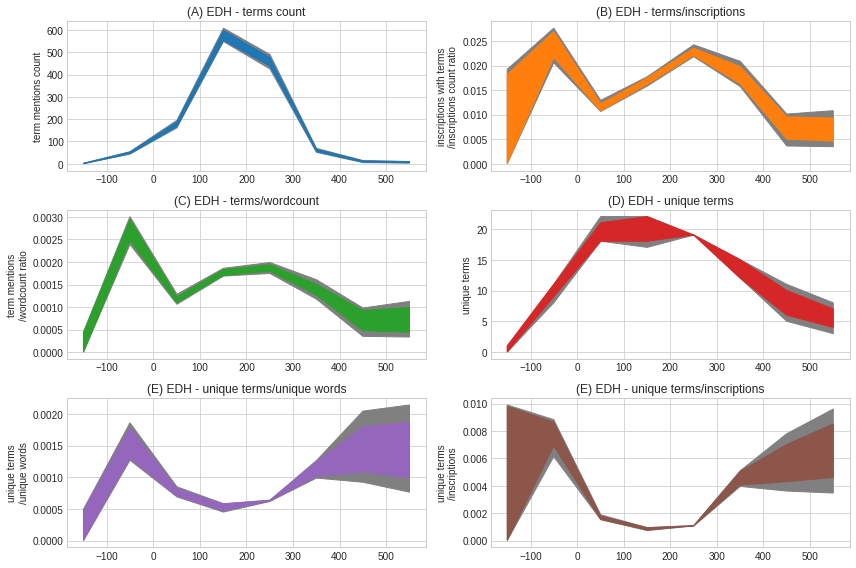

In [109]:
plt.style.use("seaborn-whitegrid")

fig, axs  = plt.subplots(3, 2, figsize=(12, 8), tight_layout=True)

for sim_data, ax, color in zip(sim_data_terms_list, axs.ravel(), tab_colors_list[:len(sim_data_list)]):
    plot_timeblocks_data(sim_data[0], ax, color)
    ax.set_title(sim_data[1])
    ax.set_ylabel(sim_data[2])
    if max([el[1] for el in sim_data[0][0]]) > 5000:
        ticks = list(ax.get_yticks())
        print(ticks)
        ticks_K = [str(int(int(tick) / 1000)) + "K" if tick != 0 else tick for tick in ticks]
        ax.set_yticklabels(ticks_K)

In [110]:
sddk.write_file("SDAM_data/epigraphic_roads/EDH_term_temporal.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/epigraphic_roads/EDH_term_temporal.png"
